# Empirical Analysis of E2E Testing in Web Applications
## Methodology Implementation
This notebook implements the methodology for the study:
"Does End-to-End Testing Pay Off? Evidence from GitHub Open-Source Repositories"

**Study Design**: Correlational research using repository mining

**Dataset**: E2EGit dataset (SQL format)

**Analysis**: Non-parametric statistical tests and correlation analysis

### 1. Setup and Configuration

In [16]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
import statsmodels.stats.multitest as multi
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import openpyxl
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


### 2. Data Loading and Validation

In [17]:
def load_and_validate_data(db_path=r"C:\Users\USER\Downloads\E2EGit.db"):
    """
    Load data from SQL database and perform initial validation.
    
    Args:
        db_path: Path to SQLite database file
        
    Returns:
        DataFrame with validated repository data
    """
    print("Loading data from SQL database...")
    
    try:
        conn = sqlite3.connect(db_path)
        
        # 1. Load non-trivial repositories (5,563 repos)
        print("\n1. Loading non-trivial repositories...")
        repo_query = """
        SELECT 
            ntr.name,
            r.stargazers,
            r.watchers,
            r.forks,
            r.contributors,
            r.commits,
            r.total_issues,
            r.open_issues,
            r.code_lines,
            r.comment_lines,
            r.blank_lines,
            r.size,
            r.created_at,
            r.updated_at,
            r.main_language,
            ntr.is_web_java,
            ntr.is_web_python,
            ntr.is_web_javascript,
            ntr.is_web_typescript
        FROM non_trivial_repository ntr
        JOIN repository r ON ntr.name = r.name
        """
        
        repos_df = pd.read_sql_query(repo_query, conn)
        print(f"   Loaded {len(repos_df)} non-trivial web repositories")
        
        # 2. Load GUI testing details (472 repos with tests)
        print("\n2. Loading GUI testing details...")
        gui_query = """
        SELECT 
            repository_name,
            number_of_tests as gui_test_count,
            number_of_files as gui_file_count,
            -- Framework usage (simplified - at least one file exists)
            CASE WHEN (COALESCE(number_files_selenium_java, 0) + 
                      COALESCE(number_files_selenium_js, 0) + 
                      COALESCE(number_files_selenium_ts, 0) + 
                      COALESCE(number_files_selenium_py, 0)) > 0 THEN 1 ELSE 0 END as uses_selenium,
            CASE WHEN (COALESCE(number_files_playwright_java, 0) + 
                      COALESCE(number_files_playwright_js, 0) + 
                      COALESCE(number_files_playwright_ts, 0) + 
                      COALESCE(number_files_playwright_py, 0)) > 0 THEN 1 ELSE 0 END as uses_playwright,
            CASE WHEN (COALESCE(number_files_puppeteer_js, 0) + 
                      COALESCE(number_files_puppeteer_ts, 0) + 
                      COALESCE(number_files_puppeteer_py, 0)) > 0 THEN 1 ELSE 0 END as uses_puppeteer,
            CASE WHEN (COALESCE(number_files_cypress_js, 0) + 
                      COALESCE(number_files_cypress_ts, 0)) > 0 THEN 1 ELSE 0 END as uses_cypress
        FROM gui_testing_repo_details
        """
        
        gui_df = pd.read_sql_query(gui_query, conn)
        print(f"   Found {len(gui_df)} repositories with GUI tests")
        
        # 3. Load performance testing details (84 repos with tests)
        print("\n3. Loading performance testing details...")
        perf_query = """
        SELECT 
            repository_name,
            COUNT(*) as perf_test_count,
            COUNT(DISTINCT test_path) as perf_file_count,
            CASE WHEN SUM(CASE WHEN is_jmeter = 1 THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END as uses_jmeter,
            CASE WHEN SUM(CASE WHEN is_locust = 1 THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END as uses_locust
        FROM performance_testing_test_details
        GROUP BY repository_name
        """
        
        perf_df = pd.read_sql_query(perf_query, conn)
        print(f"   Found {len(perf_df)} repositories with performance tests")
        
        conn.close()
        
        # 4. Merge all data
        print("\n4. Merging datasets...")
        df = repos_df.copy()
        
        # Merge GUI test data (left join - not all repos have GUI tests)
        df = pd.merge(df, gui_df, 
                     left_on='name', right_on='repository_name', 
                     how='left')
        
        # Merge performance test data (left join - not all repos have perf tests)
        df = pd.merge(df, perf_df, 
                     left_on='name', right_on='repository_name', 
                     how='left', suffixes=('', '_perf'))
        
        # 5. Create testing group classification
        print("\n5. Creating testing groups...")
        
        # Binary indicators for test presence
        df['has_gui_tests'] = df['gui_test_count'].notna()
        df['has_perf_tests'] = df['perf_test_count'].notna()
        
        # Fill NaN values for test counts with 0
        df['gui_test_count'] = df['gui_test_count'].fillna(0)
        df['gui_file_count'] = df['gui_file_count'].fillna(0)
        df['perf_test_count'] = df['perf_test_count'].fillna(0)
        df['perf_file_count'] = df['perf_file_count'].fillna(0)

        # Create total test counts
        df['total_test_count'] = df['gui_test_count'] + df['perf_test_count']

        # Fill NaN values for issues with 0
        df['total_issues'] = df['total_issues'].fillna(0)
        df['open_issues'] = df['open_issues'].fillna(0)
        
        # Create testing groups (4 categories)
        conditions = [
            (df['has_gui_tests'] & df['has_perf_tests']),  # both
            (df['has_gui_tests'] & ~df['has_perf_tests']), # gui_only
            (~df['has_gui_tests'] & df['has_perf_tests']), # perf_only
            (~df['has_gui_tests'] & ~df['has_perf_tests']) # none
        ]
        choices = ['both', 'gui_only', 'perf_only', 'none']
        df['testing_group'] = np.select(conditions, choices, default='none')
        
        # 6. Calculate additional metrics
        df['total_lines'] = df['code_lines'] + df['comment_lines'] + df['blank_lines']
        df['issue_resolution_rate'] = (df['total_issues'] - df['open_issues']) / df['total_issues'].replace(0, 1)
        
        # 7. Filter for our study (repositories with E2E tests)
        # According to paper: 472 + 84 - 13 = 543 unique repos with tests
        study_df = df[df['testing_group'] != 'none'].copy()
        
        print("\n6. Data validation summary:")
        print(f"   Total non-trivial repositories: {len(df)}")
        print(f"   Repositories with E2E tests: {len(study_df)}")
        print(f"\n   Testing group distribution:")
        group_counts = study_df['testing_group'].value_counts()
        for group, count in group_counts.items():
            print(f"   - {group}: {count} repos")
        
        # Validate against paper numbers
        print(f"\n   Validation against paper:")
        print(f"   GUI test repos: {study_df['has_gui_tests'].sum()} (paper: 472)")
        print(f"   Perf test repos: {study_df['has_perf_tests'].sum()} (paper: 84)")
        print(f"   Both test repos: {len(study_df[study_df['testing_group'] == 'both'])} (paper: 13)")
        
        # Basic sanity checks
        print(f"\n   Data quality checks:")
        print(f"   Missing values in key columns:")
        key_cols = ['stargazers', 'contributors', 'total_issues', 'code_lines']
        for col in key_cols:
            missing = study_df[col].isna().sum()
            if missing > 0:
                print(f"   - {col}: {missing} missing")
        
        print(f"   Negative values in test counts:")
        neg_gui = (study_df['gui_test_count'] < 0).sum()
        neg_perf = (study_df['perf_test_count'] < 0).sum()
        if neg_gui > 0 or neg_perf > 0:
            print(f"   - GUI tests: {neg_gui} negative")
            print(f"   - Perf tests: {neg_perf} negative")
        
        return study_df, df  # Return both: study data and full data
        
    except Exception as e:
        print(f"Error loading data: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Load the data
df = load_and_validate_data()[0] # Only the study df (The one with tests)

Loading data from SQL database...

1. Loading non-trivial repositories...
   Loaded 14053 non-trivial web repositories

2. Loading GUI testing details...
   Found 472 repositories with GUI tests

3. Loading performance testing details...
   Found 84 repositories with performance tests

4. Merging datasets...

5. Creating testing groups...

6. Data validation summary:
   Total non-trivial repositories: 14053
   Repositories with E2E tests: 543

   Testing group distribution:
   - gui_only: 459 repos
   - perf_only: 71 repos
   - both: 13 repos

   Validation against paper:
   GUI test repos: 472 (paper: 472)
   Perf test repos: 84 (paper: 84)
   Both test repos: 13 (paper: 13)

   Data quality checks:
   Missing values in key columns:
   Negative values in test counts:


In [18]:
df.columns

Index(['name', 'stargazers', 'watchers', 'forks', 'contributors', 'commits',
       'total_issues', 'open_issues', 'code_lines', 'comment_lines',
       'blank_lines', 'size', 'created_at', 'updated_at', 'main_language',
       'is_web_java', 'is_web_python', 'is_web_javascript',
       'is_web_typescript', 'repository_name', 'gui_test_count',
       'gui_file_count', 'uses_selenium', 'uses_playwright', 'uses_puppeteer',
       'uses_cypress', 'repository_name_perf', 'perf_test_count',
       'perf_file_count', 'uses_jmeter', 'uses_locust', 'has_gui_tests',
       'has_perf_tests', 'total_test_count', 'testing_group', 'total_lines',
       'issue_resolution_rate'],
      dtype='object')

### 3. RQ1: Testing Group Comparison Analysis

In [19]:
def analyze_rq1(df):
    """
    RQ1: How do repository characteristics differ between projects that adopt 
    both GUI and performance testing, versus projects that adopt only one type?
    """
    print("=" * 70)
    print("RQ1 ANALYSIS: Testing Group Comparisons")
    print("=" * 70)
    
    # Define metrics for comparison
    metrics = {
        'Popularity': ['stargazers', 'watchers', 'forks'],
        'Development Activity': ['contributors', 'commits'],
        'Issues': ['total_issues', 'open_issues'],
        'Size': ['code_lines', 'total_lines'],
        'Testing': ['gui_test_count', 'perf_test_count', 'total_test_count', 'total_test_files']
    }
    
    # Flatten metrics list for analysis
    all_metrics = []
    for category in metrics.values():
        all_metrics.extend(category)
    
    # Filter to available metrics
    available_metrics = [m for m in all_metrics if m in df.columns]
    
    print(f"Analyzing {len(available_metrics)} metrics across {len(df)} repositories")
    print(f"Groups: {df['testing_group'].unique()}")
    
    results = {
        'descriptive_stats': {},
        'kruskal_wallis': {},
        'pairwise_comparisons': {}
    }
    
    # 1. Descriptive statistics by group
    print("\n" + "="*40)
    print("DESCRIPTIVE STATISTICS (Median and IQR)")
    print("="*40)
    
    for metric in available_metrics:
        group_stats = []
        groups = df['testing_group'].unique()
        
        for group in groups:
            group_data = df[df['testing_group'] == group][metric]
            if len(group_data) > 0:
                median_val = np.median(group_data)
                q1 = np.percentile(group_data, 25)
                q3 = np.percentile(group_data, 75)
                iqr = q3 - q1
                group_stats.append({
                    'group': group,
                    'median': median_val,
                    'q1': q1,
                    'q3': q3,
                    'iqr': iqr,
                    'mean': np.mean(group_data),
                    'std': np.std(group_data),
                    'n': len(group_data)
                })
        
        results['descriptive_stats'][metric] = group_stats
        
        # Print summary for key metrics
        if metric in ['stargazers', 'contributors', 'total_issues', 'total_test_count']:
            print(f"\n{metric.upper()}:")
            for stat in group_stats:
                print(f"  {stat['group']:15} | Median: {stat['median']:8.1f} | "
                      f"IQR: [{stat['q1']:.1f}, {stat['q3']:.1f}] | n={stat['n']}")
    
    # 2. Kruskal-Wallis tests
    print("\n" + "="*40)
    print("KRUSKAL-WALLIS TESTS")
    print("="*40)
    print("H0: All groups have the same distribution")
    print("H1: At least one group differs")
    print("-"*40)
    
    for metric in available_metrics:
        groups_data = []
        group_labels = []
        
        for group in df['testing_group'].unique():
            group_data = df[df['testing_group'] == group][metric].dropna()
            if len(group_data) > 0:
                groups_data.append(group_data)
                group_labels.append(group)
        
        if len(groups_data) >= 2:
            try:
                h_stat, p_value = stats.kruskal(*groups_data)
                
                # Calculate effect size (epsilon-squared)
                n_total = sum(len(g) for g in groups_data)
                k = len(groups_data)
                epsilon_squared = (h_stat - k + 1) / (n_total - k) if n_total > k else 0
                
                results['kruskal_wallis'][metric] = {
                    'h_statistic': h_stat,
                    'p_value': p_value,
                    'epsilon_squared': epsilon_squared,
                    'n_groups': k,
                    'n_total': n_total
                }
                
                # Interpretation
                alpha = 0.05
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                
                # Only print significant results
                if p_value < 0.05:
                    print(f"{metric:25} | H = {h_stat:6.1f} | p = {p_value:.4f} {significance} | ε² = {epsilon_squared:.3f}")
                
            except Exception as e:
                print(f"{metric}: Error in test: {e}")
    
    # 3. Post-hoc pairwise comparisons for significant metrics
    print("\n" + "="*40)
    print("POST-HOC PAIRWISE COMPARISONS (Dunn's test)")
    print("="*40)
    
    significant_metrics = [m for m in available_metrics 
                          if m in results['kruskal_wallis'] 
                          and results['kruskal_wallis'][m]['p_value'] < 0.05]
    
    if significant_metrics:
        print(f"\nSignificant metrics for pairwise comparisons ({len(significant_metrics)}):")
        print(", ".join(significant_metrics))
        
        # Focus on key metrics for detailed comparison
        key_metrics = ['stargazers', 'contributors', 'total_issues', 'total_test_count']
        key_metrics = [m for m in key_metrics if m in significant_metrics]
        
        for metric in significant_metrics:
            print(f"\n{metric.upper()}:")
            
            pairwise_results = []
            groups = sorted(df['testing_group'].unique())
            
            # Perform pairwise Mann-Whitney U tests
            for i in range(len(groups)):
                for j in range(i + 1, len(groups)):
                    g1, g2 = groups[i], groups[j]
                    
                    data1 = df[df['testing_group'] == g1][metric].dropna()
                    data2 = df[df['testing_group'] == g2][metric].dropna()
                    
                    if len(data1) > 0 and len(data2) > 0:
                        try:
                            u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                            
                            # Determine which group has higher median
                            median1 = np.median(data1)
                            median2 = np.median(data2)
                            higher = g1 if median1 > median2 else g2
                            
                            pairwise_results.append({
                                'comparison': f"{g1} vs {g2}",
                                'u_statistic': u_stat,
                                'p_value': p_val,
                                'median1': median1,
                                'median2': median2,
                                'higher': higher
                            })
                            
                            # Print with significance stars
                            sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                            print(f"  {g1:12} vs {g2:12}: p = {p_val:.4f} {sig_star} (higher: {higher})")
                            
                        except Exception as e:
                            print(f"  Error comparing {g1} vs {g2}: {e}")
            
            if pairwise_results:
                # Apply Bonferroni correction
                p_values = [r['p_value'] for r in pairwise_results]
                reject, adjusted_p, _, _ = multi.multipletests(p_values, alpha=0.05, method='bonferroni')
                
                for idx, result in enumerate(pairwise_results):
                    result['adjusted_p'] = adjusted_p[idx]
                    result['significant_adj'] = reject[idx]
                
                results['pairwise_comparisons'][metric] = pairwise_results
    else:
        print("No significant differences found between groups")
    
    return results

# Run RQ1 analysis
rq1_results = analyze_rq1(df)

RQ1 ANALYSIS: Testing Group Comparisons
Analyzing 12 metrics across 543 repositories
Groups: ['both' 'gui_only' 'perf_only']

DESCRIPTIVE STATISTICS (Median and IQR)

STARGAZERS:
  both            | Median:    406.0 | IQR: [124.0, 2667.0] | n=13
  gui_only        | Median:   1224.0 | IQR: [336.5, 6314.5] | n=459
  perf_only       | Median:    466.0 | IQR: [189.5, 2464.0] | n=71

CONTRIBUTORS:
  both            | Median:     50.0 | IQR: [34.0, 86.0] | n=13
  gui_only        | Median:     79.0 | IQR: [41.0, 177.5] | n=459
  perf_only       | Median:     74.0 | IQR: [42.0, 186.0] | n=71

TOTAL_ISSUES:
  both            | Median:   1341.0 | IQR: [442.0, 1978.0] | n=13
  gui_only        | Median:    979.0 | IQR: [333.5, 2299.5] | n=459
  perf_only       | Median:   1167.0 | IQR: [158.5, 2497.0] | n=71

TOTAL_TEST_COUNT:
  both            | Median:     32.0 | IQR: [21.0, 63.0] | n=13
  gui_only        | Median:     19.0 | IQR: [5.0, 70.0] | n=459
  perf_only       | Median:      2.0 | IQR: [

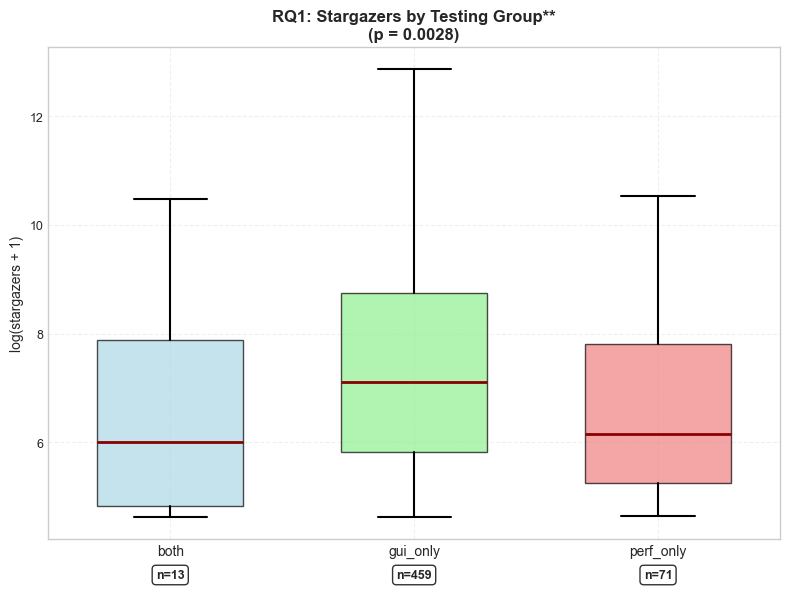

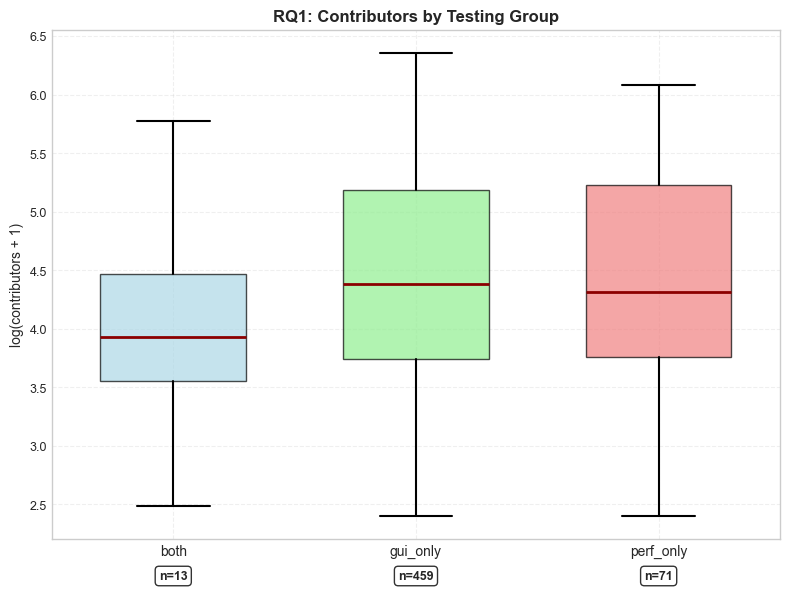

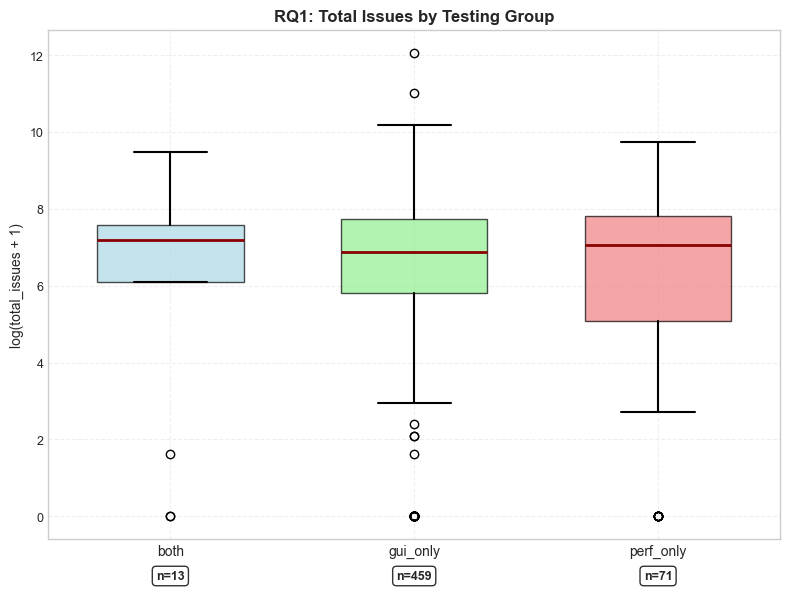

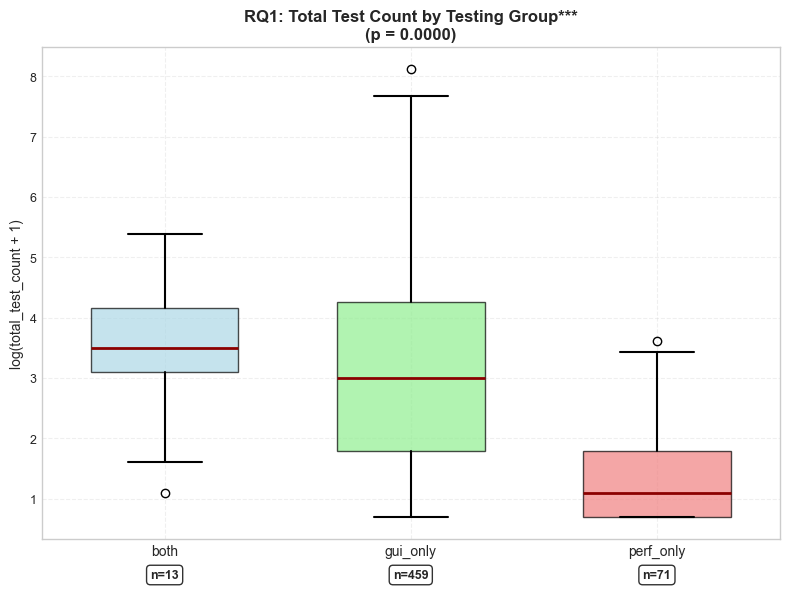

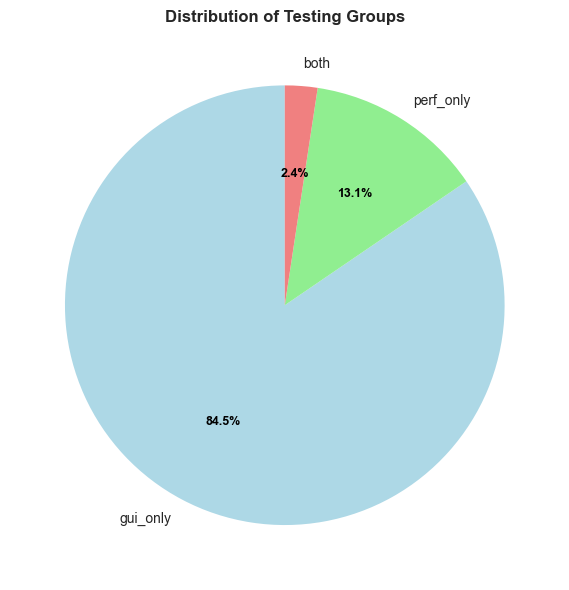

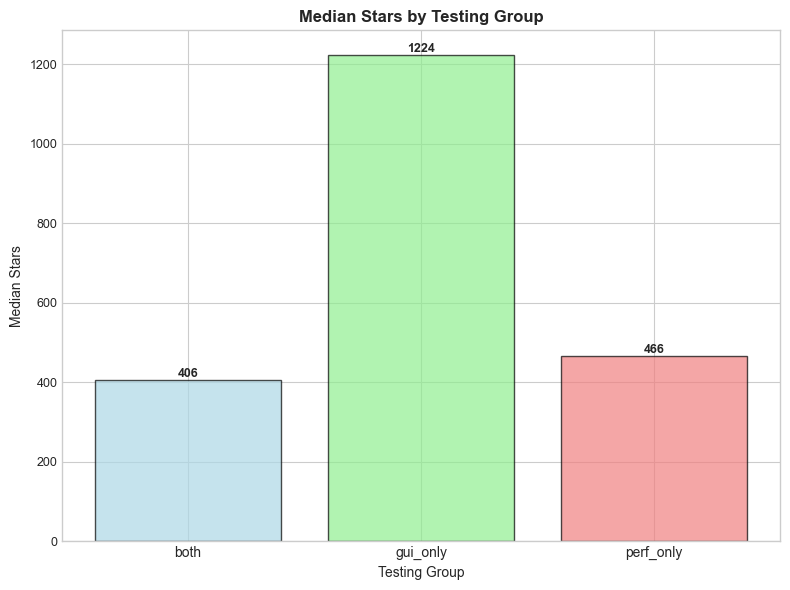

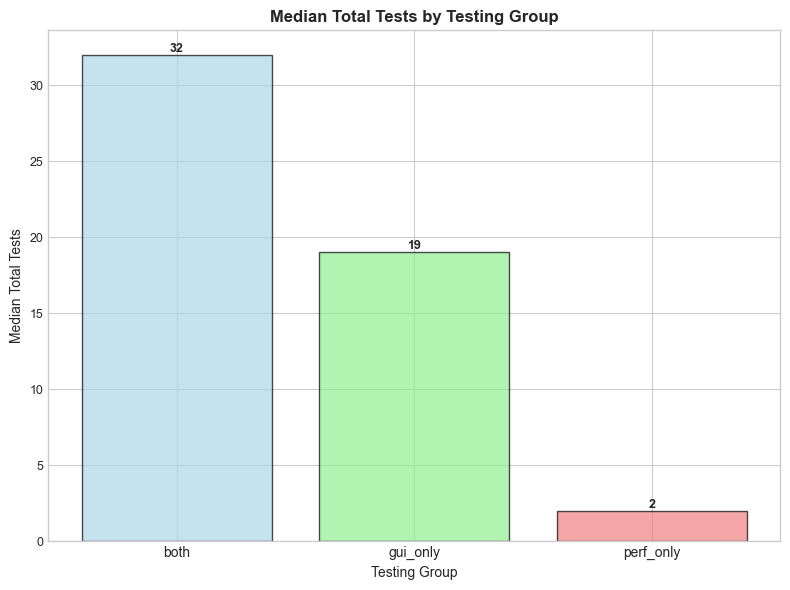

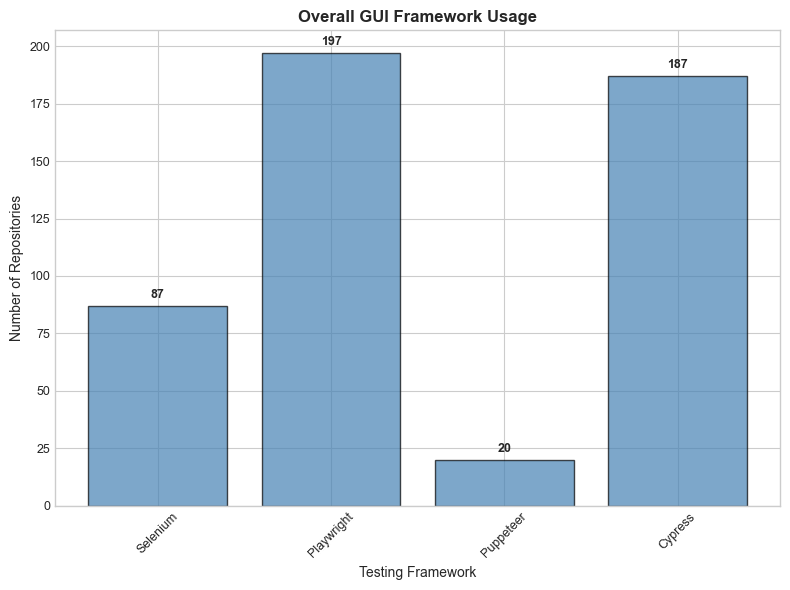

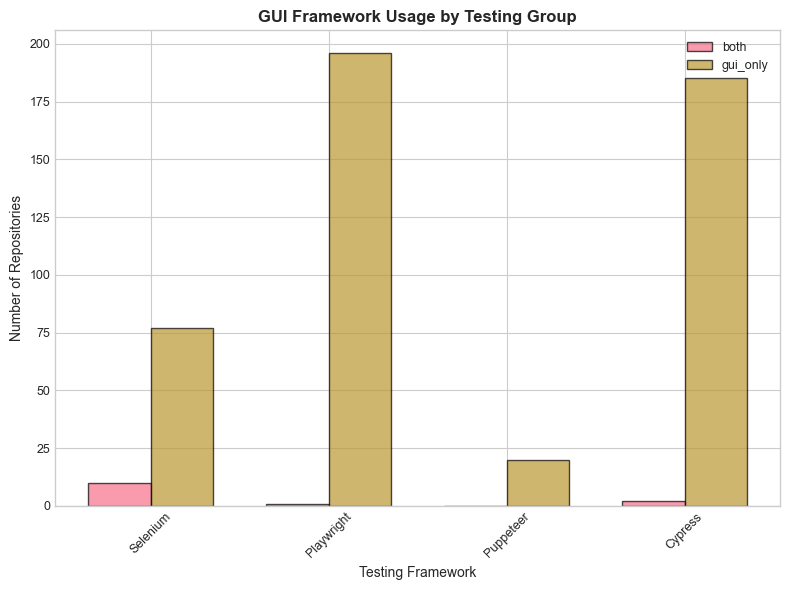

In [20]:
def create_rq1_visualizations(df, results):
    """Create visualizations for RQ1 results."""
    # 1. Main comparison: Key metrics by testing group
    key_metrics = ['stargazers', 'contributors', 'total_issues', 'total_test_count']
    
    for metric in key_metrics:
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Prepare data for boxplot
        plot_data = []
        group_labels = []
        groups = sorted(df['testing_group'].unique())
        
        for group in groups:
            group_data = df[df['testing_group'] == group][metric]
            if len(group_data) > 0:
                # Apply log transformation for skewed data
                if metric in ['stargazers', 'contributors', 'total_issues', 'total_test_count']:
                    plot_data.append(np.log1p(group_data))
                else:
                    plot_data.append(group_data)
                group_labels.append(group)
        
        if plot_data:
            # Create boxplot
            bp = ax.boxplot(plot_data, labels=group_labels, patch_artist=True, widths=0.6)
            
            # Color boxes
            colors = ['lightblue', 'lightgreen', 'lightcoral']
            for patch, color in zip(bp['boxes'], colors[:len(group_labels)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
                patch.set_edgecolor('black')
            
            # Customize whiskers and caps
            for whisker in bp['whiskers']:
                whisker.set(color='black', linewidth=1.5)
            for cap in bp['caps']:
                cap.set(color='black', linewidth=1.5)
            for median in bp['medians']:
                median.set(color='darkred', linewidth=2)
            
            # Add title with significance
            title = f'RQ1: {metric.replace("_", " ").title()} by Testing Group'
            if metric in results.get('kruskal_wallis', {}):
                p_val = results['kruskal_wallis'][metric]['p_value']
                if p_val < 0.05:
                    stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
                    title += f'{stars}\n(p = {p_val:.4f})'
            
            ax.set_title(title, fontweight='bold', fontsize=12)
            
            # Set y-axis label
            if metric in ['stargazers', 'contributors', 'total_issues', 'total_test_count']:
                ax.set_ylabel(f'log({metric} + 1)', fontsize=10)
            else:
                ax.set_ylabel(metric, fontsize=10)
            
            # Add sample size annotations
            for i, group in enumerate(group_labels):
                n = len(df[df['testing_group'] == group])
                # Get current y-axis limits
                y_min, y_max = ax.get_ylim()
                # Calculate position just below the bottom of the plot
                # Use 6% of the y-range below the minimum, just enough so both are clearly visible
                y_pos = y_min - (y_max - y_min) * 0.06
                ax.text(i + 1, y_pos, f'n={n}', 
                       ha='center', va='top', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            # Improve tick labels
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=9)
            
            # Add grid
            ax.grid(True, alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()
    
    # 2. Group distribution and summary statistics
    create_group_summary_visualizations(df)
    
    # 3. Framework usage visualization
    create_framework_visualizations(df)

def create_group_summary_visualizations(df):
    """Create summary visualizations for groups."""
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    # 1. Group sizes (pie chart)
    fig, ax = plt.subplots(figsize=(8, 6))
    group_counts = df['testing_group'].value_counts()
    
    wedges, texts, autotexts = ax.pie(group_counts.values, labels=group_counts.index,
                                       autopct='%1.1f%%', colors=colors[:len(group_counts)],
                                       startangle=90, textprops={'fontsize': 10})
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    ax.set_title('Distribution of Testing Groups', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 2. Average stars by group (bar chart)
    fig, ax = plt.subplots(figsize=(8, 6))
    group_stars = df.groupby('testing_group')['stargazers'].median()
    bars = ax.bar(group_stars.index, group_stars.values, 
                   color=colors[:len(group_stars)], alpha=0.7, edgecolor='black')
    ax.set_xlabel('Testing Group', fontsize=10)
    ax.set_ylabel('Median Stars', fontsize=10)
    ax.set_title('Median Stars by Testing Group', fontweight='bold', fontsize=12)
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.tick_params(axis='y', labelsize=9)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Test count by group (if column exists)
    if 'total_test_count' in df.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        group_tests = df.groupby('testing_group')['total_test_count'].median()
        bars = ax.bar(group_tests.index, group_tests.values, 
                       color=colors[:len(group_tests)], alpha=0.7, edgecolor='black')
        ax.set_xlabel('Testing Group', fontsize=10)
        ax.set_ylabel('Median Total Tests', fontsize=10)
        ax.set_title('Median Total Tests by Testing Group', fontweight='bold', fontsize=12)
        ax.tick_params(axis='x', labelsize=10, rotation=0)
        ax.tick_params(axis='y', labelsize=9)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

def create_framework_visualizations(df):
    """Visualize testing framework usage."""
    framework_cols = ['uses_selenium', 'uses_playwright', 'uses_puppeteer', 'uses_cypress']
    available_frameworks = [col for col in framework_cols if col in df.columns]
    
    if available_frameworks:
        # 1. Overall framework usage 
        fig, ax = plt.subplots(figsize=(8, 6))
        
        framework_counts = [df[col].sum() for col in available_frameworks]
        framework_names = [col.replace('uses_', '').title() for col in available_frameworks]
        
        bars = ax.bar(framework_names, framework_counts, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Testing Framework', fontsize=10)
        ax.set_ylabel('Number of Repositories', fontsize=10)
        ax.set_title('Overall GUI Framework Usage', fontweight='bold', fontsize=12)
        ax.tick_params(axis='x', labelsize=9, rotation=45)
        ax.tick_params(axis='y', labelsize=9)
        
        # Add count labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                    str(int(height)), ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Framework usage by testing group 
        fig, ax = plt.subplots(figsize=(8, 6))
        groups = ['both', 'gui_only']
        group_data = {}
        
        for group in groups:
            group_df = df[df['testing_group'] == group]
            group_counts = [group_df[col].sum() for col in available_frameworks]
            group_data[group] = group_counts
        
        x = np.arange(len(framework_names))
        width = 0.35
        
        for i, (group, counts) in enumerate(group_data.items()):
            offset = width * i - width/2
            ax.bar(x + offset, counts, width, label=group, alpha=0.7, edgecolor='black')
        
        ax.set_xlabel('Testing Framework', fontsize=10)
        ax.set_ylabel('Number of Repositories', fontsize=10)
        ax.set_title('GUI Framework Usage by Testing Group', fontweight='bold', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(framework_names, rotation=45, fontsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.legend(fontsize=9)

        plt.tight_layout()
        plt.show()

# Generate RQ1 visualizations
create_rq1_visualizations(df, rq1_results)

In [21]:
def analyze_rq2(df):
    """
    RQ2: For repositories with at least one issue, can their test suite 
    characteristics be correlated with the number of reported issues?
    """
    print("=" * 70)
    print("RQ2 ANALYSIS: Test Suite Characteristics and Issues")
    print("=" * 70)
    
    # Filter repositories with at least one issue
    df_with_issues = df[df['total_issues'] > 0].copy()
    print(f"Repositories with at least one issue: {len(df_with_issues)}")
    
    if len(df_with_issues) == 0:
        print("No repositories with issues found.")
        return {}, df_with_issues
    
    results = {
        'correlations': {},
        'partial_correlations': {},
        'stratified_analysis': {}
    }
    
    # Test suite characteristics to analyze
    test_metrics = ['gui_test_count', 'gui_file_count', 
                    'perf_test_count', 'perf_file_count',
                    'total_test_count', 'total_test_files']
    
    # Filter to available metrics
    available_test_metrics = [m for m in test_metrics if m in df_with_issues.columns]
    
    print("\n" + "="*40)
    print("SPEARMAN'S RANK CORRELATIONS")
    print("="*40)
    print("Correlation between test metrics and total issues")
    print("-"*40)
    
    for test_metric in available_test_metrics:
        # Filter valid data (positive test counts and issues)
        valid_data = df_with_issues[[test_metric, 'total_issues']].dropna()
        valid_data = valid_data[(valid_data[test_metric] > 0) & (valid_data['total_issues'] > 0)]
        
        if len(valid_data) > 10:  # Need sufficient data
            corr_coef, p_value = stats.spearmanr(valid_data[test_metric], valid_data['total_issues'])
            
            interpretation = interpret_correlation(corr_coef)
            
            results['correlations'][test_metric] = {
                'correlation': corr_coef,
                'p_value': p_value,
                'n': len(valid_data),
                'interpretation': interpretation
            }
            
            # Print with significance stars
            sig_star = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"{test_metric:25} | rho = {corr_coef:6.3f} | p = {p_value:.4f} {sig_star:3} | n = {len(valid_data):4} | {interpretation}")
            
            # Calculate issue density (issues per KLOC) if code_lines available
            if 'code_lines' in df_with_issues.columns:
                df_with_issues['issue_density'] = df_with_issues['total_issues'] / (df_with_issues['code_lines'] / 1000)
                valid_density = df_with_issues[[test_metric, 'issue_density']].dropna()
                valid_density = valid_density[(valid_density[test_metric] > 0) & (valid_density['issue_density'] > 0)]
                
                if len(valid_density) > 10:
                    density_corr, density_p = stats.spearmanr(valid_density[test_metric], valid_density['issue_density'])
                    
                    results['correlations'][f'{test_metric}_density'] = {
                        'correlation': density_corr,
                        'p_value': density_p,
                        'n': len(valid_density)
                    }
            
    
    print("\n" + "="*40)
    print("PARTIAL CORRELATIONS (Controlling for Repository Size)")
    print("="*40)
    
    if 'code_lines' in df_with_issues.columns:
        for test_metric in ['total_test_count', 'total_test_files']:
            if test_metric in available_test_metrics and test_metric in results['correlations']:
                # Prepare data for partial correlation
                partial_data = df_with_issues[['total_issues', test_metric, 'code_lines', 'contributors']].dropna()
                partial_data = partial_data[(partial_data[test_metric] > 0) & 
                                           (partial_data['total_issues'] > 0) &
                                           (partial_data['code_lines'] > 0)]
                
                if len(partial_data) > 10:
                    try:
                        # Simple approach: residual correlation
                        # We'll control for code_lines and contributors
                        X_control = partial_data[['code_lines', 'contributors']]
                        y_test = partial_data[test_metric]
                        y_issues = partial_data['total_issues']
                        
                        # Get residuals after controlling for size and contributors
                        from sklearn.linear_model import LinearRegression
                        model_test = LinearRegression().fit(X_control, y_test)
                        model_issues = LinearRegression().fit(X_control, y_issues)
                        
                        residuals_test = y_test - model_test.predict(X_control)
                        residuals_issues = y_issues - model_issues.predict(X_control)
                        
                        # Correlation of residuals
                        partial_corr, partial_p = stats.spearmanr(residuals_test, residuals_issues)
                        
                        results['partial_correlations'][test_metric] = {
                            'partial_correlation': partial_corr,
                            'p_value': partial_p,
                            'n': len(partial_data)
                        }
                        
                        sig_star = "***" if partial_p < 0.001 else "**" if partial_p < 0.01 else "*" if partial_p < 0.05 else ""
                        print(f"{test_metric:25} | Partial rho = {partial_corr:6.3f} | p = {partial_p:.4f} {sig_star:3} | n = {len(partial_data):4}")
                        
                    except Exception as e:
                        print(f"Error calculating partial correlation for {test_metric}: {e}")
    
    print("\n" + "="*40)
    print("STRATIFIED ANALYSIS BY TESTING GROUP")
    print("="*40)
    
    for test_metric in ['total_test_count', 'gui_test_count']:
        if test_metric in available_test_metrics:
            print(f"\n{test_metric.upper()}:")
            
            for group in ['both', 'gui_only', 'perf_only']:
                group_data = df_with_issues[df_with_issues['testing_group'] == group]
                valid_data = group_data[[test_metric, 'total_issues']].dropna()
                valid_data = valid_data[(valid_data[test_metric] > 0) & (valid_data['total_issues'] > 0)]
                
                if len(valid_data) > 5:
                    corr, p_val = stats.spearmanr(valid_data[test_metric], valid_data['total_issues'])
                    sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"  {group:15}: rho = {corr:.3f}{sig_star:3} (n={len(valid_data)})")
    
    print("\n" + "="*40)
    print("ISSUE DENSITY CORRELATIONS (Issues per KLOC)")
    print("="*40)

    # Print the stored issue density correlations
    for metric_name, result in results['correlations'].items():
        if '_density' in metric_name:
            base_metric = metric_name.replace('_density', '')
            corr = result['correlation']
            p_val = result['p_value']
            n = result['n']
            
            sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            interpretation = interpret_correlation(corr)
            
            print(f"{base_metric:25} | rho = {corr:6.3f} | p = {p_val:.4f} {sig_star:3} | n = {n:4} | {interpretation}")
            
    return results, df_with_issues

def interpret_correlation(rho):
    """Interpret correlation coefficient magnitude."""
    abs_rho = abs(rho)
    if abs_rho < 0.1:
        return "negligible"
    elif abs_rho < 0.3:
        return "weak"
    elif abs_rho < 0.5:
        return "moderate"
    else:
        return "strong"

# Run RQ2 analysis
rq2_results, df_with_issues = analyze_rq2(df)

RQ2 ANALYSIS: Test Suite Characteristics and Issues
Repositories with at least one issue: 496

SPEARMAN'S RANK CORRELATIONS
Correlation between test metrics and total issues
----------------------------------------
gui_test_count            | rho =  0.085 | p = 0.0761     | n =  434 | negligible
gui_file_count            | rho =  0.068 | p = 0.1591     | n =  434 | negligible
perf_test_count           | rho = -0.084 | p = 0.4785     | n =   73 | negligible
perf_file_count           | rho =  0.077 | p = 0.5178     | n =   73 | negligible
total_test_count          | rho =  0.058 | p = 0.2006     | n =  496 | negligible

PARTIAL CORRELATIONS (Controlling for Repository Size)
total_test_count          | Partial rho =  0.220 | p = 0.0000 *** | n =  496

STRATIFIED ANALYSIS BY TESTING GROUP

TOTAL_TEST_COUNT:
  both           : rho = -0.291    (n=11)
  gui_only       : rho = 0.091    (n=423)
  perf_only      : rho = -0.177    (n=62)

GUI_TEST_COUNT:
  both           : rho = -0.173    (n=11)



RQ2 VISUALIZATIONS


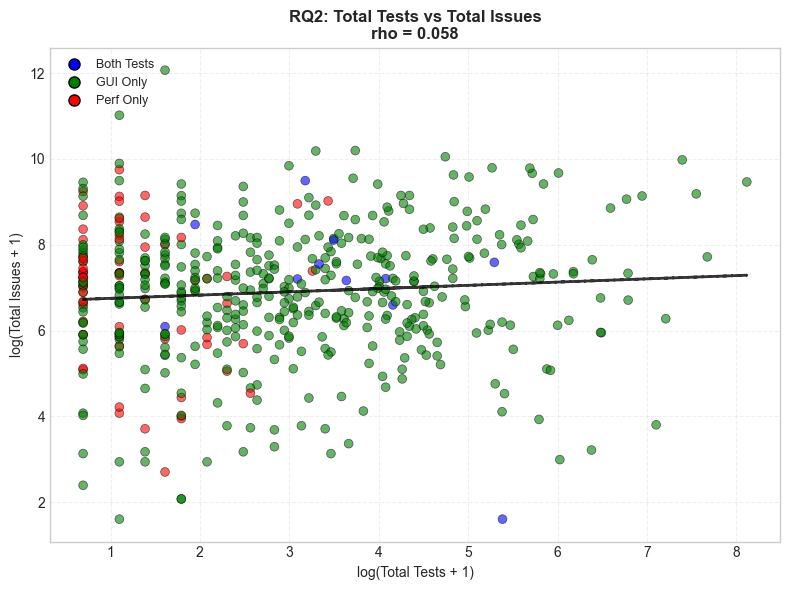

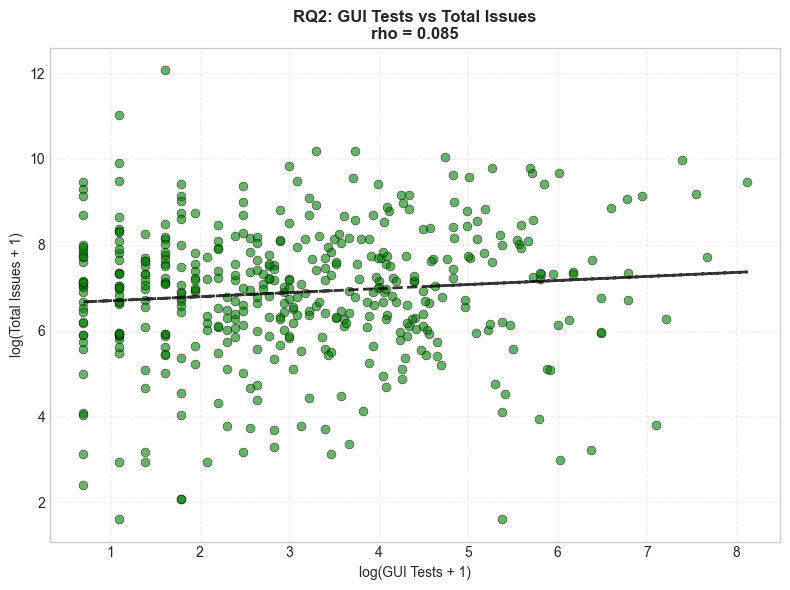

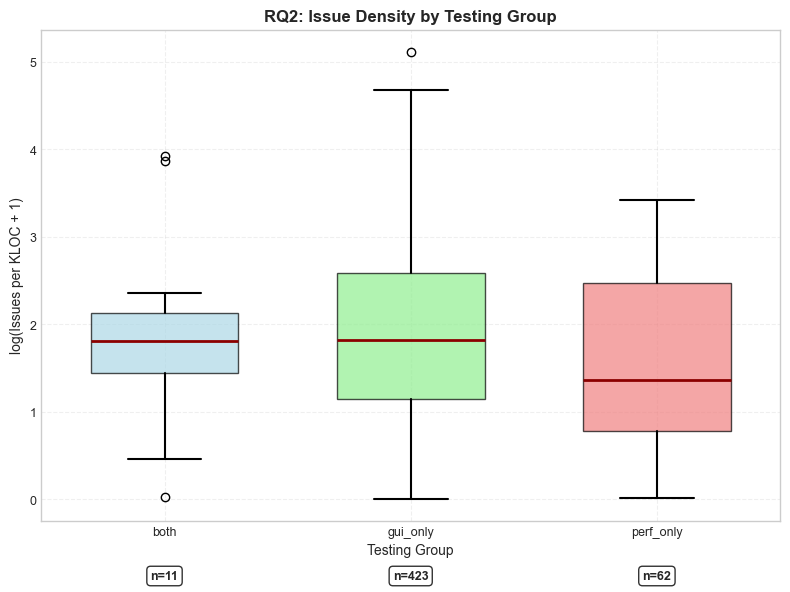

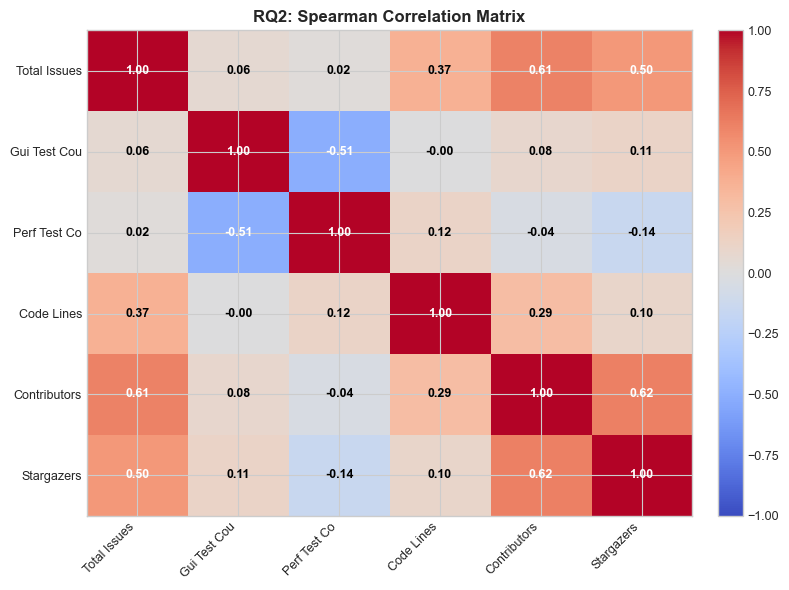

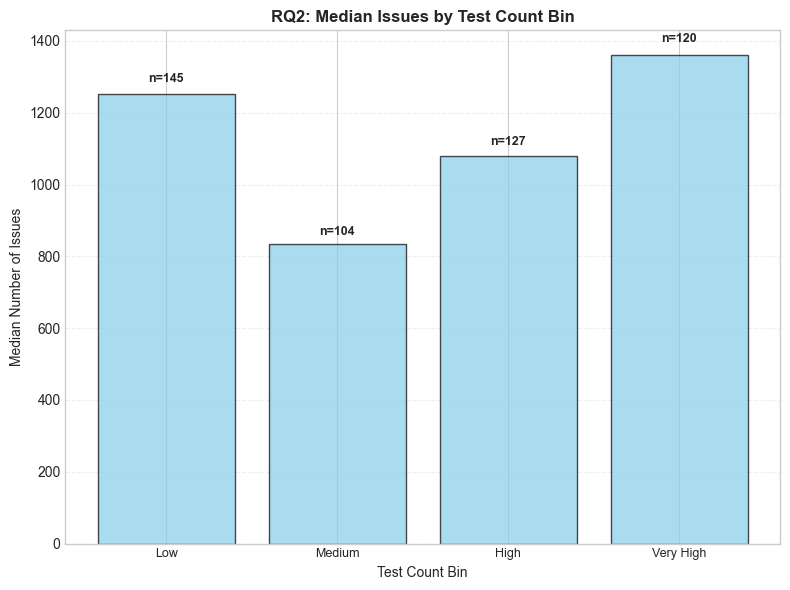

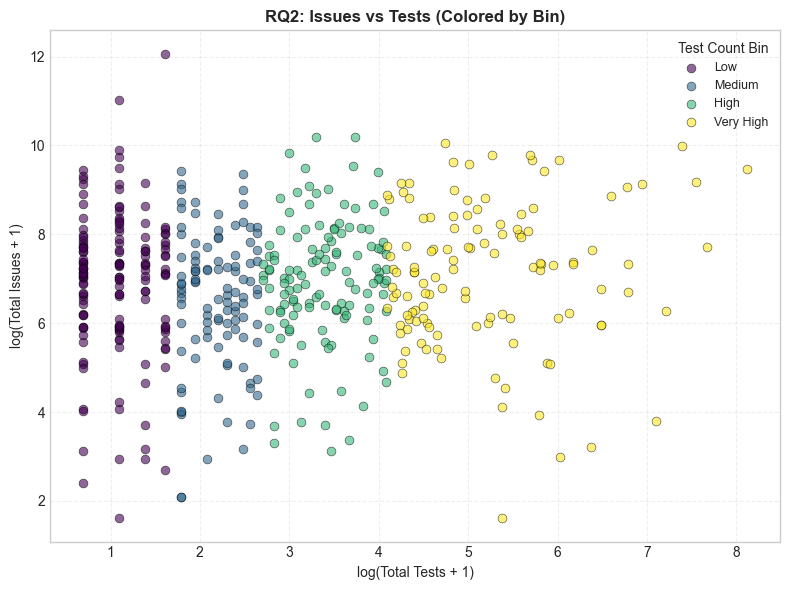

In [ ]:
def create_rq2_visualizations(df_with_issues, results):
    """Create visualizations for RQ2 results."""
    
    if len(df_with_issues) == 0:
        print("No data for visualization.")
        return
    
    # 1. Scatter plot: Total tests vs Issues
    if 'total_test_count' in df_with_issues.columns:
        valid_data = df_with_issues[['total_test_count', 'total_issues']].dropna()
        valid_data = valid_data[(valid_data['total_test_count'] > 0) & (valid_data['total_issues'] > 0)]
        
        if len(valid_data) > 0:
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # Log transform for better visualization
            x = np.log1p(valid_data['total_test_count'])
            y = np.log1p(valid_data['total_issues'])
            
            # Color by testing group
            colors = []
            for idx in valid_data.index:
                group = df_with_issues.loc[idx, 'testing_group']
                color_map = {'both': 'blue', 'gui_only': 'green', 'perf_only': 'red'}
                colors.append(color_map.get(group, 'gray'))
            
            scatter = ax.scatter(x, y, alpha=0.6, s=40, c=colors, edgecolors='black', linewidth=0.5)
            
            # Add trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), "k--", alpha=0.8, linewidth=2)
            
            # Add correlation info
            corr_info = results['correlations'].get('total_test_count', {})
            if corr_info:
                rho = corr_info.get('correlation', 0)
                p_val = corr_info.get('p_value', 1)
                sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                ax.set_title(f'RQ2: Total Tests vs Total Issues\nrho = {rho:.3f}{sig_star}', 
                             fontweight='bold', fontsize=12)
            else:
                ax.set_title('RQ2: Total Tests vs Total Issues', fontweight='bold', fontsize=12)
            
            ax.set_xlabel('log(Total Tests + 1)', fontsize=10)
            ax.set_ylabel('log(Total Issues + 1)', fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add legend for colors
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                      markersize=8, label='Both Tests', markeredgecolor='black'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                      markersize=8, label='GUI Only', markeredgecolor='black'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                      markersize=8, label='Perf Only', markeredgecolor='black')
            ]
            ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
            
            plt.tight_layout()
            plt.show()
    
    # 2. Scatter plot: GUI tests vs Issues
    if 'gui_test_count' in df_with_issues.columns:
        valid_data = df_with_issues[['gui_test_count', 'total_issues']].dropna()
        valid_data = valid_data[(valid_data['gui_test_count'] > 0) & (valid_data['total_issues'] > 0)]
        
        if len(valid_data) > 0:
            fig, ax = plt.subplots(figsize=(8, 6))
            
            x = np.log1p(valid_data['gui_test_count'])
            y = np.log1p(valid_data['total_issues'])
            
            ax.scatter(x, y, alpha=0.6, s=40, color='green', edgecolors='black', linewidth=0.5)
            
            # Add trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), "k--", alpha=0.8, linewidth=2)
            
            corr_info = results['correlations'].get('gui_test_count', {})
            if corr_info:
                rho = corr_info.get('correlation', 0)
                p_val = corr_info.get('p_value', 1)
                sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                ax.set_title(f'RQ2: GUI Tests vs Total Issues\nrho = {rho:.3f}{sig_star}', 
                             fontweight='bold', fontsize=12)
            else:
                ax.set_title('RQ2: GUI Tests vs Total Issues', fontweight='bold', fontsize=12)
            
            ax.set_xlabel('log(GUI Tests + 1)', fontsize=10)
            ax.set_ylabel('log(Total Issues + 1)', fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()
    
    # 3. Boxplot: Issue density by testing group
    if 'code_lines' in df_with_issues.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Calculate issue density
        df_with_issues['issue_density'] = df_with_issues['total_issues'] / (df_with_issues['code_lines'] / 1000)
        
        # Prepare data for boxplot
        plot_data = []
        groups = ['both', 'gui_only', 'perf_only']
        group_labels = []
        
        for group in groups:
            group_data = df_with_issues[df_with_issues['testing_group'] == group]['issue_density']
            if len(group_data) > 0:
                # Filter positive values and log transform
                positive_data = group_data[group_data > 0]
                if len(positive_data) > 0:
                    plot_data.append(np.log1p(positive_data))
                    group_labels.append(group)
        
        if plot_data:
            bp = ax.boxplot(plot_data, labels=group_labels, patch_artist=True, widths=0.6)
            
            colors = ['lightblue', 'lightgreen', 'lightcoral']
            for patch, color in zip(bp['boxes'], colors[:len(group_labels)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
                patch.set_edgecolor('black')
            
            # Customize whiskers and caps
            for whisker in bp['whiskers']:
                whisker.set(color='black', linewidth=1.5)
            for cap in bp['caps']:
                cap.set(color='black', linewidth=1.5)
            for median in bp['medians']:
                median.set(color='darkred', linewidth=2)
            
            ax.set_title('RQ2: Issue Density by Testing Group', fontweight='bold', fontsize=12)
            ax.set_ylabel('log(Issues per KLOC + 1)', fontsize=10)
            ax.set_xlabel('Testing Group', fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.tick_params(axis='both', labelsize=9)
            
            # Add sample sizes
            for i, group in enumerate(group_labels):
                n = len(df_with_issues[df_with_issues['testing_group'] == group])
                # Get current y-axis limits
                y_min, y_max = ax.get_ylim()
                # Calculate position just below the bottom of the plot
                # Use 106% of the y-range below the minimum, just enough so both are clearly visible
                y_pos = y_min - (y_max - y_min) * 0.1
                ax.text(i + 1, y_pos, f'n={n}', 
                        ha='center', va='top', fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            plt.tight_layout()
            plt.show()
    
    # 4. Correlation heatmap
    # Select variables for correlation matrix
    corr_vars = ['total_issues', 'gui_test_count', 'perf_test_count', 
                'code_lines', 'contributors', 'stargazers']
    
    available_corr_vars = [v for v in corr_vars if v in df_with_issues.columns]
    
    if len(available_corr_vars) >= 3:
        corr_data = df_with_issues[available_corr_vars].dropna()
        
        if len(corr_data) > 0:
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # Calculate Spearman correlations
            corr_matrix = corr_data.corr(method='spearman')
            
            # Create heatmap
            im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
            
            # Add correlation values
            for i in range(len(corr_matrix)):
                for j in range(len(corr_matrix)):
                    value = corr_matrix.iloc[i, j]
                    color = 'white' if abs(value) > 0.5 else 'black'
                    ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                            color=color, fontweight='bold', fontsize=9)
            
            ax.set_xticks(range(len(corr_matrix)))
            ax.set_yticks(range(len(corr_matrix)))
            ax.set_xticklabels([v.replace('_', ' ').title()[:12] for v in corr_matrix.columns], 
                               rotation=45, ha='right', fontsize=9)
            ax.set_yticklabels([v.replace('_', ' ').title()[:12] for v in corr_matrix.columns], 
                               fontsize=9)
            ax.set_title('RQ2: Spearman Correlation Matrix', fontweight='bold', fontsize=12)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=9)
            
            plt.tight_layout()
            plt.show()
    
    # Additional visualization: Binned analysis
    create_binned_analysis(df_with_issues)

def create_binned_analysis(df_with_issues):
    """Create binned analysis visualization."""
    if 'total_test_count' in df_with_issues.columns and 'total_issues' in df_with_issues.columns:
        # Bin by test count
        df_filtered = df_with_issues[(df_with_issues['total_test_count'] > 0) & 
                                    (df_with_issues['total_issues'] > 0)].copy()
        
        if len(df_filtered) > 10:
            try:
                # Create bins based on test count percentiles
                df_filtered['test_bin'] = pd.qcut(df_filtered['total_test_count'], 
                                                 q=4, 
                                                 labels=['Low', 'Medium', 'High', 'Very High'])
                
                # Calculate statistics per bin
                bin_stats = df_filtered.groupby('test_bin').agg({
                    'total_issues': ['median', 'count'],
                    'total_test_count': 'median'
                }).reset_index()
                
                bin_stats.columns = ['test_bin', 'median_issues', 'count', 'median_tests']
                
                # 1. Bar plot: Median issues by test bin
                fig, ax = plt.subplots(figsize=(8, 6))
                bars = ax.bar(range(len(bin_stats)), bin_stats['median_issues'], 
                             color='skyblue', edgecolor='black', alpha=0.7)
                ax.set_xticks(range(len(bin_stats)))
                ax.set_xticklabels(bin_stats['test_bin'], fontsize=9)
                ax.set_xlabel('Test Count Bin', fontsize=10)
                ax.set_ylabel('Median Number of Issues', fontsize=10)
                ax.set_title('RQ2: Median Issues by Test Count Bin', fontweight='bold', fontsize=12)
                ax.grid(True, alpha=0.3, axis='y', linestyle='--')
                
                # Add count annotations
                for i, (_, row) in enumerate(bin_stats.iterrows()):
                    ax.text(i, row['median_issues'] * 1.02, f'n={int(row["count"])}', 
                            ha='center', va='bottom', fontsize=9, fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
                # 2. Scatter with bins colored
                fig, ax = plt.subplots(figsize=(8, 6))
                colors = plt.cm.viridis(np.linspace(0, 1, 4))
                color_dict = {label: color for label, color in 
                             zip(['Low', 'Medium', 'High', 'Very High'], colors)}
                
                for label, color in color_dict.items():
                    bin_data = df_filtered[df_filtered['test_bin'] == label]
                    if len(bin_data) > 0:
                        ax.scatter(np.log1p(bin_data['total_test_count']), 
                                  np.log1p(bin_data['total_issues']),
                                  color=color, alpha=0.6, s=40, label=label, edgecolors='black', linewidth=0.5)
                
                ax.set_xlabel('log(Total Tests + 1)', fontsize=10)
                ax.set_ylabel('log(Total Issues + 1)', fontsize=10)
                ax.set_title('RQ2: Issues vs Tests (Colored by Bin)', fontweight='bold', fontsize=12)
                ax.legend(title='Test Count Bin', fontsize=9, title_fontsize=10)
                ax.grid(True, alpha=0.3, linestyle='--')
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Could not create binned visualization: {e}")

# Generate RQ2 visualizations
create_rq2_visualizations(df_with_issues, rq2_results)

In [23]:
def perform_robustness_checks(df):
    """
    Perform robustness checks to validate main findings.
    """
    print("=" * 70)
    print("ROBUSTNESS CHECKS")
    print("=" * 70)
    
    print("\n1. SENSITIVITY TO OUTLIERS")
    print("-" * 40)
    
    # Remove extreme outliers (top 5%)
    df_no_outliers = df.copy()
    for col in ['stargazers', 'total_issues', 'total_test_count', 'code_lines']:
        if col in df.columns:
            q95 = df[col].quantile(0.95)
            df_no_outliers = df_no_outliers[df_no_outliers[col] <= q95]
    
    print(f"Analysis without extreme outliers (top 5% removed)")
    print(f"Sample size: {len(df_no_outliers)} (was {len(df)})")
    
    # Re-run key analyses on subset
    if len(df_no_outliers) > 30:
        print("\nRe-running key correlations without outliers:")
        
        # Key correlations to check
        test_metrics = ['total_test_count', 'gui_test_count']
        
        for test_metric in test_metrics:
            if test_metric in df_no_outliers.columns:
                valid_data = df_no_outliers[[test_metric, 'total_issues']].dropna()
                valid_data = valid_data[(valid_data[test_metric] > 0) & (valid_data['total_issues'] > 0)]
                
                if len(valid_data) > 10:
                    corr, p_val = stats.spearmanr(valid_data[test_metric], valid_data['total_issues'])
                    sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"  {test_metric:20}: rho = {corr:.3f}{sig_star} (n={len(valid_data)})")
    
    print("\n\n2. PROGRAMMING LANGUAGE STRATIFICATION")
    print("-" * 40)
    
    if 'main_language' in df.columns:
        top_languages = df['main_language'].value_counts().head(3).index.tolist()
        
        print(f"Top languages: {top_languages}")
        
        for lang in top_languages:
            df_lang = df[df['main_language'] == lang].copy()
            
            if len(df_lang) > 10:
                # Test correlation for this language
                valid_data = df_lang[['total_test_count', 'total_issues']].dropna()
                valid_data = valid_data[(valid_data['total_test_count'] > 0) & (valid_data['total_issues'] > 0)]
                
                if len(valid_data) > 5:
                    corr, p_val = stats.spearmanr(valid_data['total_test_count'], valid_data['total_issues'])
                    sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"  {lang:20}: rho = {corr:.3f}{sig_star} (n={len(valid_data)})")
    
    print("\n\n3. MINIMUM TEST THRESHOLD SENSITIVITY")
    print("-" * 40)
    
    if 'total_test_count' in df.columns:
        thresholds = [1, 5, 10]
        
        for threshold in thresholds:
            df_threshold = df[df['total_test_count'] >= threshold].copy()
            
            if len(df_threshold) > 10:
                valid_data = df_threshold[['total_test_count', 'total_issues']].dropna()
                valid_data = valid_data[(valid_data['total_test_count'] > 0) & (valid_data['total_issues'] > 0)]
                
                if len(valid_data) > 5:
                    corr, p_val = stats.spearmanr(valid_data['total_test_count'], valid_data['total_issues'])
                    sig_star = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"  Tests ≥ {threshold:2}: rho = {corr:.3f}{sig_star} (n={len(valid_data)})")
    
    return df_no_outliers

# Perform robustness checks
df_no_outliers = perform_robustness_checks(df)

ROBUSTNESS CHECKS

1. SENSITIVITY TO OUTLIERS
----------------------------------------
Analysis without extreme outliers (top 5% removed)
Sample size: 454 (was 543)

Re-running key correlations without outliers:
  total_test_count    : rho = 0.066 (n=410)
  gui_test_count      : rho = 0.090 (n=358)


2. PROGRAMMING LANGUAGE STRATIFICATION
----------------------------------------
Top languages: ['TypeScript', 'Java', 'JavaScript']
  TypeScript          : rho = 0.133 (n=206)
  Java                : rho = 0.033 (n=101)
  JavaScript          : rho = 0.002 (n=79)


3. MINIMUM TEST THRESHOLD SENSITIVITY
----------------------------------------
  Tests ≥  1: rho = 0.058 (n=496)
  Tests ≥  5: rho = 0.145** (n=351)
  Tests ≥ 10: rho = 0.119* (n=284)


In [24]:
def summarize_findings(rq1_results, rq2_results, df):
    """
    Generate a summary of key findings.
    """
    print("=" * 70)
    print("SUMMARY OF KEY FINDINGS")
    print("=" * 70)
    
    print("\n1. RQ1: TESTING GROUP COMPARISONS")
    print("-" * 40)
    
    # Count significant differences
    significant_metrics = []
    for metric, result in rq1_results.get('kruskal_wallis', {}).items():
        if result and result['p_value'] < 0.05:
            significant_metrics.append((metric, result['p_value'], result['epsilon_squared']))
    
    if significant_metrics:
        print(f"Found {len(significant_metrics)} metrics with significant differences between groups:")
        print("\nKey significant differences:")
        
        # Sort by p-value and show top 5
        for metric, p_val, eff_size in sorted(significant_metrics, key=lambda x: x[1])[:5]:
            # Find which group has highest median
            group_stats = rq1_results['descriptive_stats'].get(metric, [])
            if group_stats:
                highest_group = max(group_stats, key=lambda x: x['median'])
                print(f"  • {metric.replace('_', ' ').title()}:")
                print(f"    p = {p_val:.4f}, ε² = {eff_size:.3f}")
                print(f"    Highest median in '{highest_group['group']}' group: {highest_group['median']:.1f}")
    else:
        print("No significant differences found between testing groups")
    
    print("\n\n2. RQ2: TEST-ISSUE CORRELATIONS")
    print("-" * 40)
    
    # Summarize key correlations
    key_metrics = ['total_test_count', 'gui_test_count', 'gui_file_count']
    
    print("Key correlations with total issues:")
    for test_metric in key_metrics:
        if test_metric in rq2_results.get('correlations', {}):
            corr_info = rq2_results['correlations'][test_metric]
            sig_star = "***" if corr_info['p_value'] < 0.001 else "**" if corr_info['p_value'] < 0.01 else "*" if corr_info['p_value'] < 0.05 else ""
            print(f"  • {test_metric.replace('_', ' ').title()}:")
            print(f"    rho = {corr_info['correlation']:.3f}{sig_star}, p = {corr_info['p_value']:.4f}")
            print(f"    Interpretation: {corr_info['interpretation']} correlation")
            
            # Check partial correlation
            if test_metric in rq2_results.get('partial_correlations', {}):
                partial_info = rq2_results['partial_correlations'][test_metric]
                partial_sig = "***" if partial_info['p_value'] < 0.001 else "**" if partial_info['p_value'] < 0.01 else "*" if partial_info['p_value'] < 0.05 else ""
                print(f"    Partial rho (controlling for size): {partial_info['partial_correlation']:.3f}{partial_sig}")
    
    print("\n\n3. PRACTICAL IMPLICATIONS")
    print("-" * 40)
    
    print("Based on our analysis:")
    
    # RQ1 implications
    if 'stargazers' in rq1_results.get('kruskal_wallis', {}):
        stars_p = rq1_results['kruskal_wallis']['stargazers']['p_value']
        if stars_p < 0.05:
            group_stats = rq1_results['descriptive_stats'].get('stargazers', [])
            if group_stats:
                highest_group = max(group_stats, key=lambda x: x['median'])
                print(f"Projects with '{highest_group['group']}' testing tend to have the most stars")
    
    # RQ2 implications
    if 'total_test_count' in rq2_results.get('correlations', {}):
        corr_info = rq2_results['correlations']['total_test_count']
        if corr_info['p_value'] < 0.05:
            if corr_info['correlation'] < 0:
                print(f"More total tests associate with fewer issues (rho = {corr_info['correlation']:.3f})")
            elif corr_info['correlation'] > 0:
                print(f"More total tests associate with more issues (rho = {corr_info['correlation']:.3f})")
            else:
                print("No linear relationship between total tests and issues")
        else:
            print("No significant correlation between total test count and issues")
    

# Generate summary
summarize_findings(rq1_results, rq2_results, df)

SUMMARY OF KEY FINDINGS

1. RQ1: TESTING GROUP COMPARISONS
----------------------------------------
Found 6 metrics with significant differences between groups:

Key significant differences:
  • Perf Test Count:
    p = 0.0000, ε² = 0.991
    Highest median in 'both' group: 2.0
  • Gui Test Count:
    p = 0.0000, ε² = 0.340
    Highest median in 'both' group: 19.0
  • Total Test Count:
    p = 0.0000, ε² = 0.149
    Highest median in 'both' group: 32.0
  • Stargazers:
    p = 0.0028, ε² = 0.018
    Highest median in 'gui_only' group: 1224.0
  • Total Lines:
    p = 0.0072, ε² = 0.015
    Highest median in 'both' group: 324922.0


2. RQ2: TEST-ISSUE CORRELATIONS
----------------------------------------
Key correlations with total issues:
  • Total Test Count:
    rho = 0.058, p = 0.2006
    Interpretation: negligible correlation
    Partial rho (controlling for size): 0.220***
  • Gui Test Count:
    rho = 0.085, p = 0.0761
    Interpretation: negligible correlation
  • Gui File Count:


In [25]:
def export_results(rq1_results, rq2_results, df, filename='analysis_results.xlsx'):
    """
    Export analysis results to Excel for reporting.
    """
    print(f"\nExporting results to {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # 1. Repository summary
            summary_cols = ['name', 'testing_group', 'stargazers', 'watchers', 'forks', 
                          'contributors', 'commits', 'total_issues', 'open_issues',
                          'code_lines', 'gui_test_count', 'perf_test_count', 
                          'total_test_count', 'main_language']
            available_summary_cols = [col for col in summary_cols if col in df.columns]
            
            if available_summary_cols:
                df[available_summary_cols].to_excel(writer, sheet_name='Repository_Summary', index=False)
            
            # 2. RQ1: Descriptive statistics
            desc_data = []
            for metric, stats_list in rq1_results.get('descriptive_stats', {}).items():
                for stat in stats_list:
                    desc_data.append({
                        'Metric': metric,
                        'Group': stat['group'],
                        'Median': stat['median'],
                        'Q1': stat['q1'],
                        'Q3': stat['q3'],
                        'IQR': stat['iqr'],
                        'Mean': stat['mean'],
                        'Std': stat['std'],
                        'n': stat['n']
                    })
            
            if desc_data:
                pd.DataFrame(desc_data).to_excel(writer, sheet_name='RQ1_Descriptive', index=False)
            
            # 3. RQ1: Statistical tests
            kw_data = []
            for metric, result in rq1_results.get('kruskal_wallis', {}).items():
                if result:
                    kw_data.append({
                        'Metric': metric,
                        'H_Statistic': result['h_statistic'],
                        'p_value': result['p_value'],
                        'Epsilon_Squared': result['epsilon_squared'],
                        'Effect_Size': ('Negligible' if result['epsilon_squared'] < 0.01 
                                      else 'Small' if result['epsilon_squared'] < 0.06 
                                      else 'Medium' if result['epsilon_squared'] < 0.14 
                                      else 'Large'),
                        'n_groups': result['n_groups'],
                        'n_total': result['n_total']
                    })
            
            if kw_data:
                pd.DataFrame(kw_data).to_excel(writer, sheet_name='RQ1_Statistical', index=False)
            
            # 4. RQ2: Correlation results
            corr_data = []
            for metric, result in rq2_results.get('correlations', {}).items():
                if result:
                    corr_data.append({
                        'Test_Metric': metric,
                        'Correlation_Type': 'Spearman',
                        'rho': result.get('correlation', np.nan),
                        'p_value': result.get('p_value', np.nan),
                        'n': result.get('n', 0),
                        'Interpretation': result.get('interpretation', '')
                    })
            
            if corr_data:
                pd.DataFrame(corr_data).to_excel(writer, sheet_name='RQ2_Correlations', index=False)
            
            # 5. RQ2: Partial correlations
            partial_data = []
            for metric, result in rq2_results.get('partial_correlations', {}).items():
                if result:
                    partial_data.append({
                        'Test_Metric': metric,
                        'Partial_Correlation': result.get('partial_correlation', np.nan),
                        'p_value': result.get('p_value', np.nan),
                        'n': result.get('n', 0)
                    })
            
            if partial_data:
                pd.DataFrame(partial_data).to_excel(writer, sheet_name='RQ2_Partial', index=False)
        
        print("Export completed successfully!")
        print(f"Results saved to {filename}")
        
    except Exception as e:
        print(f"Error exporting results: {e}")

# Export results
export_results(rq1_results, rq2_results, df)


Exporting results to analysis_results.xlsx...
Export completed successfully!
Results saved to analysis_results.xlsx
